In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
from utils import access_raster
from glob import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import gaussian_kde
import seaborn as sns
import random
from scipy import optimize

In [3]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/3.Basedataset/"
aspect_path = basepath + "Slope"
hs_path = basepath + "HS"

is_tiff = lambda x: re.search(".tiff?$", x)

def get_dataframe(path, key): 
    files = filter(is_tiff, glob(path + "/**/*", recursive=True))
    df = pd.DataFrame(files, columns=[key])
    df['file'] = df[key].apply(lambda p: Path(p).parts[-2])
    df = df.set_index("file")
    return df

def get_array(raster): 
    array = raster['array'][0]
    nodata = raster['meta']['nodata']
    array[array==nodata]=0
    return array

In [4]:
df = get_dataframe(aspect_path, "Slope")[1:]
df['HS'] = get_dataframe(hs_path, "HS")['HS']
len(df)

15

In [5]:
def get_mapping(series):
    aspect_raster = access_raster(series['Slope'])
    hs_raster = access_raster(series['HS'])

    aspect_array = get_array(aspect_raster)
    hs_array = get_array(hs_raster)
    
    mapping = [[a, hs] for aspect_line, hs_line in zip(aspect_array, hs_array) 
                       for a, hs in zip(aspect_line, hs_line)
                       if hs > 0]
    
    return mapping

        
def fit_curve(x, y, ax): 
    def test_func(x, a, b, c, d):
        return a * x**3 + b * x**2 + c * x + d

    try:
        params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0, 1, 0],
                                                    method="trf", absolute_sigma=True, maxfev=5000)
    except RuntimeError: 
        print("Optimal parameters not found, fit won't be displayed")
        plt.show()
        return None
        
    x, y = zip(*sorted(zip(x, y)))
    x, y = np.array(x), np.array(y)
    fitted_y = test_func(x, params[0], params[1], params[2], params[3])
    ax.plot(x, fitted_y,
            label='Linear regression', color="red")
    ax.legend(loc='best')
    plt.show()    
    
    get_str = lambda x:  f"{round(x, 2)}"
    a, b, c, d = params
    print(f"Fitted function: {get_str(a)} * x^3 + {get_str(b)} * x^2 + {get_str(c)} * x + {get_str(d)}")
    
    
    mse = np.mean((y - fitted_y) ** 2)
    print("MSE:", mse)
    ss_res = np.sum((y - fitted_y) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (ss_res / ss_tot)
    print("R^2:", r_sq)
    
    return r_sq

def plot_map(_mapping):
    mapping = deepcopy(_mapping)
    random.shuffle(mapping)

    x, y = zip(*mapping[:10000])
    x, y = np.array(x), np.array(y)
    xy = np.vstack([x,y])
    kernel = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=kernel, s=1, label="scatter plot")
    
    fit_curve(x, y, ax)
    
    return x

def plot_slices(mapping): 
    df = pd.DataFrame(mapping)
    df[0] = df[0].apply(lambda x: round(x, 2))
    new_mapping = df.groupby(0).apply(np.mean, axis=0).values

    plot_map(new_mapping)
    return df

____________________________________________________________________________________________________ 
 HS_Saflischpass_20220512_1m_epsg2056


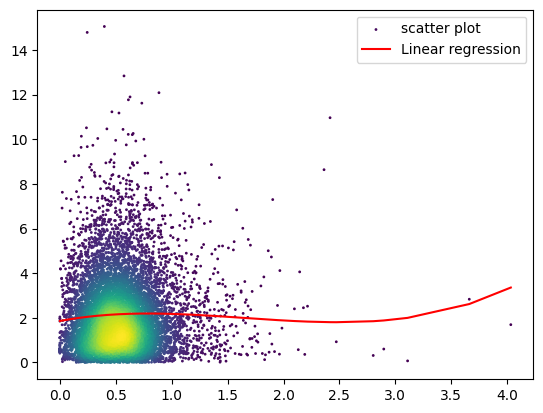

Fitted function: 0.16 * x^3 + -0.78 * x^2 + 0.94 * x + 1.86
MSE: 2.741613
R^2: 0.001967906951904297


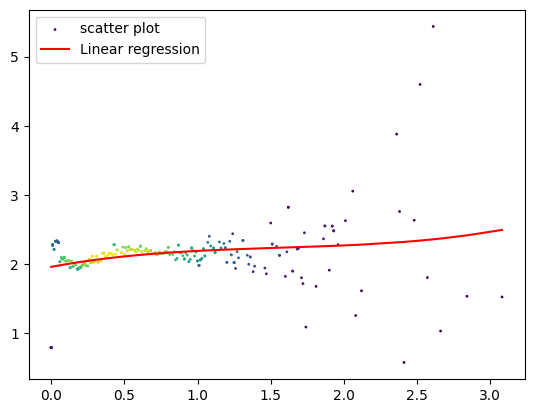

Fitted function: 0.04 * x^3 + -0.21 * x^2 + 0.4 * x + 1.96
MSE: 0.14760597714500023
R^2: 0.06444196962565973
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220511_1m_epsg2056


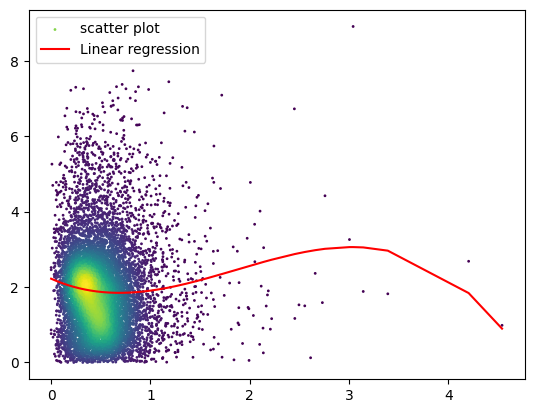

Fitted function: -0.19 * x^3 + 1.05 * x^2 + -1.18 * x + 2.22
MSE: 1.3881693
R^2: 0.00606006383895874


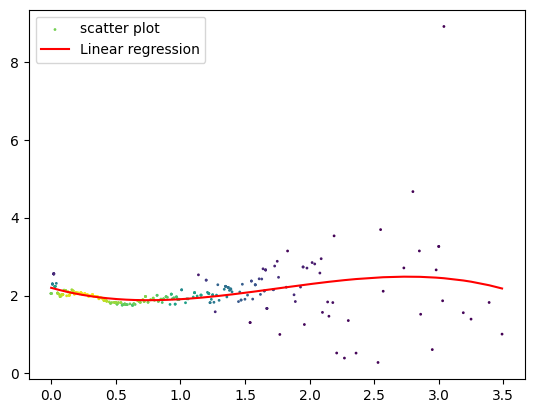

Fitted function: -0.15 * x^3 + 0.79 * x^2 + -0.93 * x + 2.2
MSE: 0.2724943761852205
R^2: 0.07783104889658643
____________________________________________________________________________________________________ 
 snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser


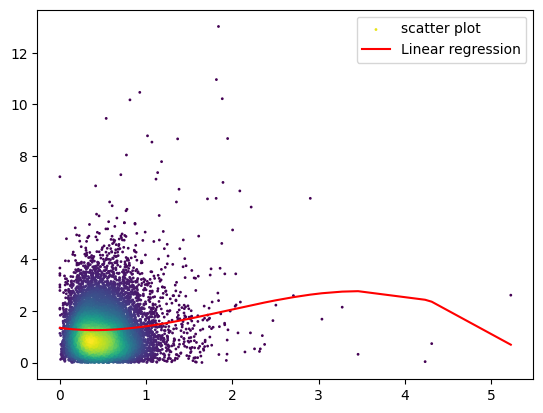

Fitted function: -0.11 * x^3 + 0.61 * x^2 + -0.44 * x + 1.34
MSE: 0.94719815
R^2: 0.00868898630142212


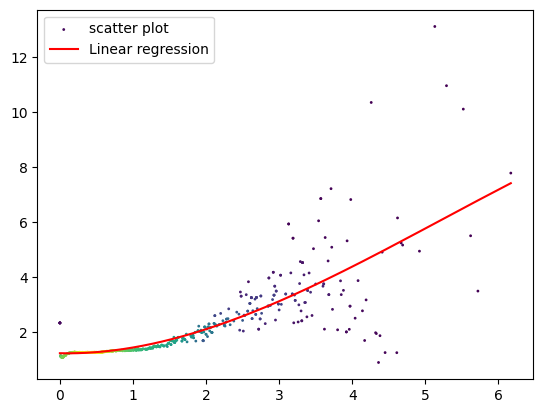

Fitted function: -0.02 * x^3 + 0.28 * x^2 + -0.06 * x + 1.24
MSE: 0.6248302861745978
R^2: 0.6457170708902716
____________________________________________________________________________________________________ 
 HS_Davos_20200406_2m_epsg2056


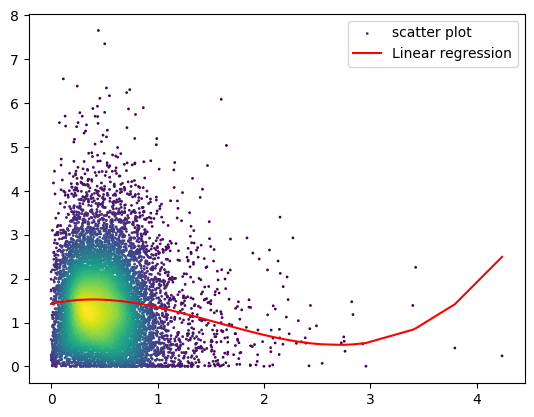

Fitted function: 0.17 * x^3 + -0.78 * x^2 + 0.54 * x + 1.43
MSE: 0.9223596
R^2: 0.012060046195983887


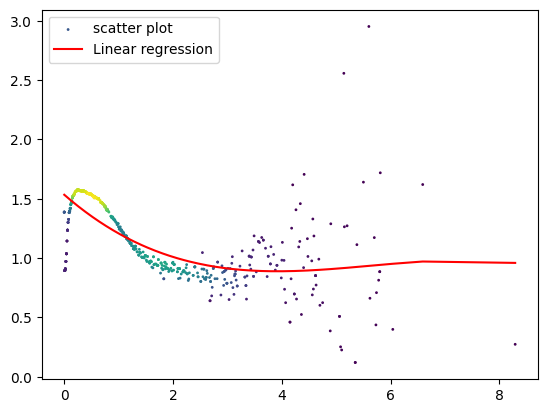

Fitted function: -0.0 * x^3 + 0.08 * x^2 + -0.4 * x + 1.53
MSE: 0.05287569598180309
R^2: 0.47316210637306677
____________________________________________________________________________________________________ 
 HS_Davos_20211604_2m_epsg2056


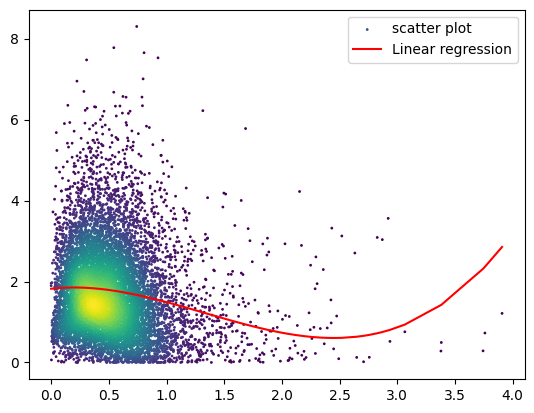

Fitted function: 0.22 * x^3 + -0.87 * x^2 + 0.32 * x + 1.82
MSE: 1.1583675
R^2: 0.024185121059417725


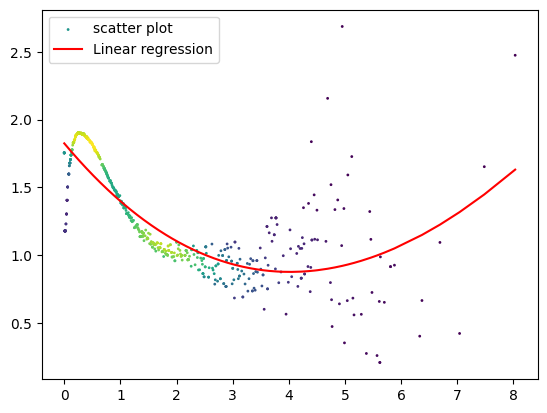

Fitted function: -0.0 * x^3 + 0.07 * x^2 + -0.5 * x + 1.82
MSE: 0.05667575307445923
R^2: 0.6376431875585927
____________________________________________________________________________________________________ 
 snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser


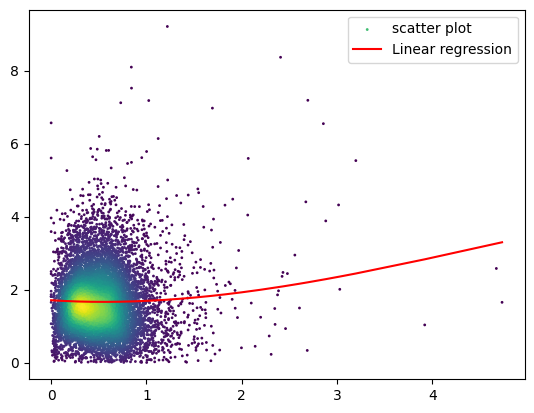

Fitted function: -0.01 * x^3 + 0.16 * x^2 + -0.17 * x + 1.71
MSE: 0.75084335
R^2: 0.0020717382431030273


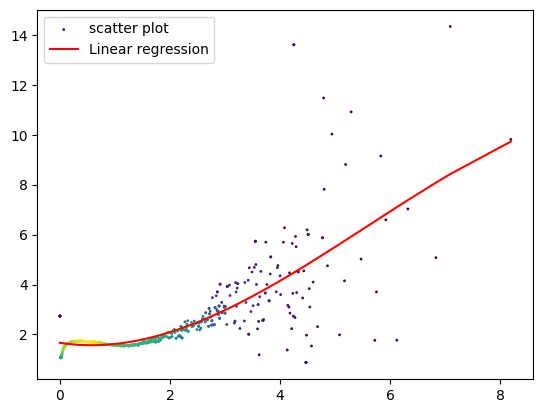

Fitted function: -0.02 * x^3 + 0.32 * x^2 + -0.35 * x + 1.66
MSE: 0.934676597265486
R^2: 0.5808897654735428
____________________________________________________________________________________________________ 
 snowmap_2012_ads_80_extent_maskiert_nosnow0_noausreisser


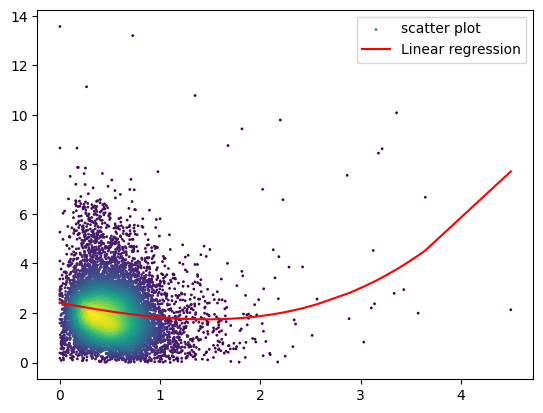

Fitted function: 0.08 * x^3 + 0.09 * x^2 + -0.75 * x + 2.41
MSE: 1.3367674
R^2: 0.020404458045959473


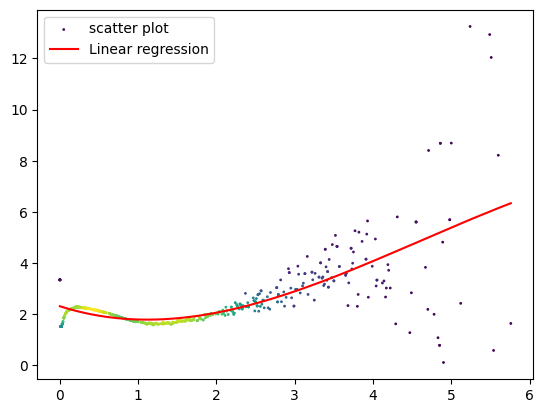

Fitted function: -0.04 * x^3 + 0.5 * x^2 + -0.98 * x + 2.31
MSE: 0.7405351534366301
R^2: 0.488511064915478
____________________________________________________________________________________________________ 
 snowmap_2015_ads_100_extent_maskiert_nosnow0_noausreisser


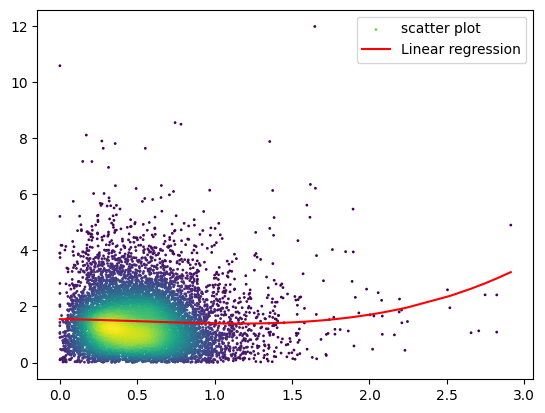

Fitted function: 0.16 * x^3 + -0.26 * x^2 + -0.05 * x + 1.55
MSE: 0.9671692
R^2: 0.003445148468017578


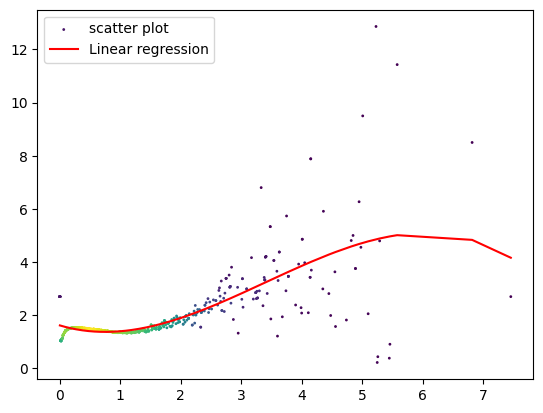

Fitted function: -0.05 * x^3 + 0.51 * x^2 + -0.68 * x + 1.62
MSE: 0.6831335624136543
R^2: 0.5083710295460058
____________________________________________________________________________________________________ 
 snowmap_20160126_ads_100_extent_maskiert_nosnow0_noausreisser


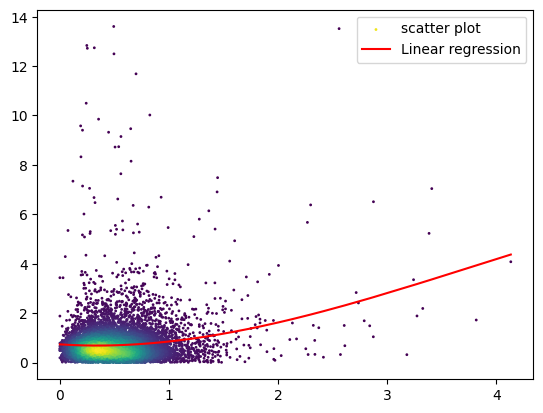

Fitted function: -0.04 * x^3 + 0.44 * x^2 + -0.29 * x + 0.73
MSE: 0.5901596
R^2: 0.02727043628692627


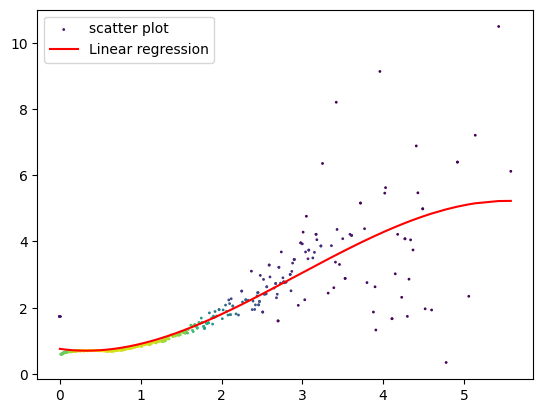

Fitted function: -0.06 * x^3 + 0.56 * x^2 + -0.35 * x + 0.76
MSE: 0.43649350834339345
R^2: 0.7388546790402637
____________________________________________________________________________________________________ 
 HS_c_20220223_1m_epsg2056


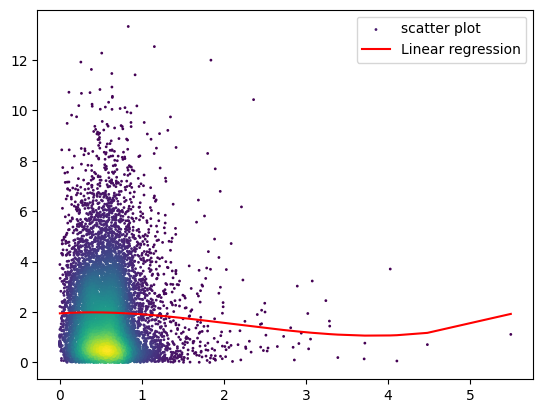

Fitted function: 0.05 * x^3 + -0.29 * x^2 + 0.21 * x + 1.95
MSE: 3.2776434
R^2: 0.0012273192405700684


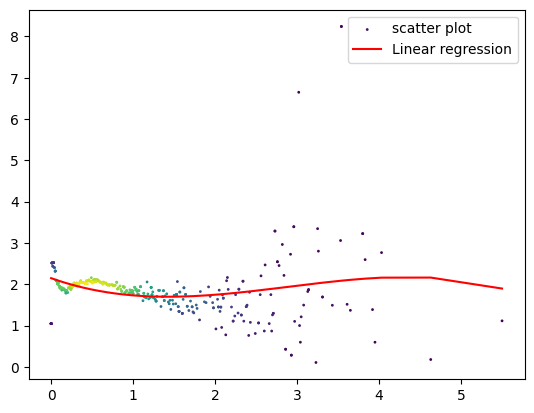

Fitted function: -0.04 * x^3 + 0.33 * x^2 + -0.71 * x + 2.15
MSE: 0.4175319668630297
R^2: 0.04833092693158114
____________________________________________________________________________________________________ 
 HS_Davos_20170316_2m_epsg2056


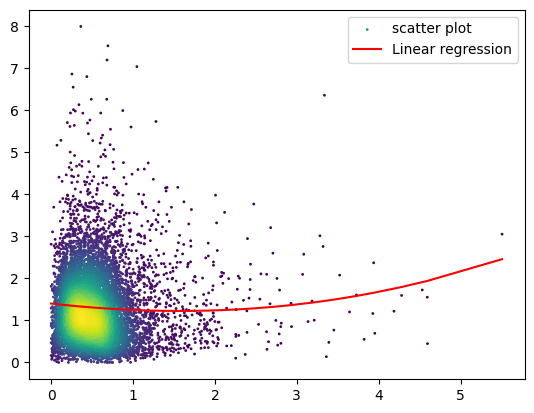

Fitted function: 0.0 * x^3 + 0.07 * x^2 + -0.22 * x + 1.4
MSE: 0.6845087
R^2: 0.0028748512268066406


In [6]:
for index, series in df.iterrows(): 
    print("_"*100, "\n", series.name)
    mapping = get_mapping(series)
    plot_map(mapping)
    new_mapping = plot_slices(mapping)